# Assignment 4 - part 1
Lauri Pessi | bft860

## Dataset: municipal_key_figures.xlsx

In [1]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression

In [2]:
# Fetch data and take a peek
df = pd.read_excel('http://myy.haaga-helia.fi/~menetelmat/Data-analytiikka/Teaching/municipal_key_figures.xlsx')
m = int(df.shape[0])
print('Rows: ' + str(m))
print('Cols: ' + str(df.shape[1]))

Rows: 689
Cols: 33


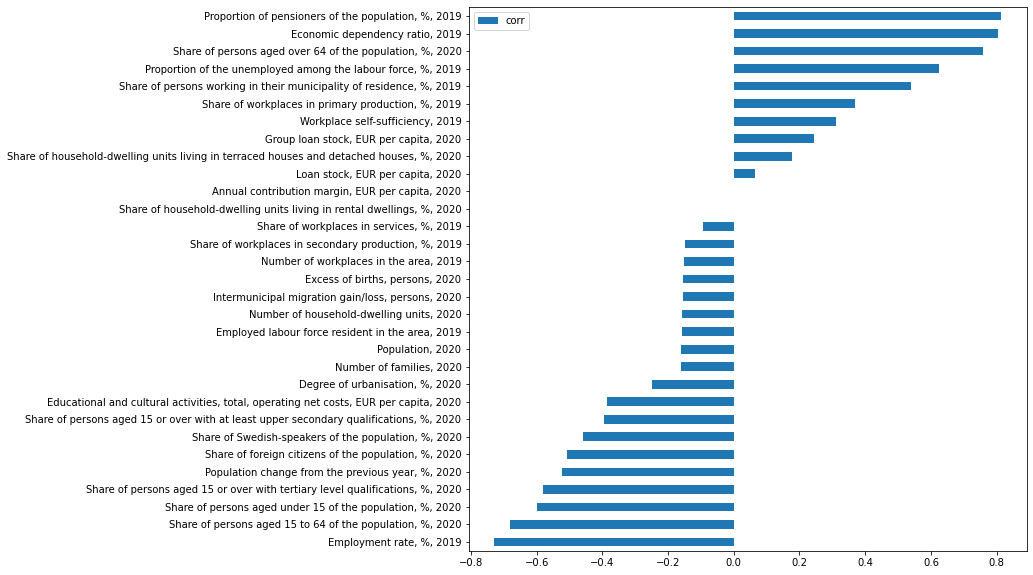

In [3]:
# Set dependent variable
y_name = 'Social and health care activities, total, operating net costs, EUR per capita, 2020'
y = df[y_name]


# Let's try selecting independent variables based on their correlation against y

# To avoid one-hotting etc. trickery with caterigorical variables, we'll just pick the numerics.
x_cands = df.drop(y_name, axis=1).select_dtypes(exclude='object').columns

# Calculate correlations against y for each
corrs = []
for c in x_cands:
    corrs.append(y.corr(df[c], method='pearson'))
   
dfc = pd.DataFrame({'x':x_cands, 'corr':corrs}, index=x_cands)

# And finally visualize the results
dfc.sort_values('corr').plot.barh(figsize=(10,10));

In [4]:
# Finally we can pick the strongly correlated variables based on their coefficent of +- 0.5  
# And just for the sake of being fancy, let's order these best first

dfc['corr_abs'] = abs(dfc['corr'])

x_names = dfc[(dfc['corr']>=0.5) | (dfc['corr']<=-0.5)].sort_values('corr_abs', ascending=False).x
x = df[x_names]

print('Picked ' + str(x.shape[1]) + ' independent variables out of ' + str(x_cands.shape[0]) + ' candidates.')


Picked 11 independent variables out of 31 candidates.


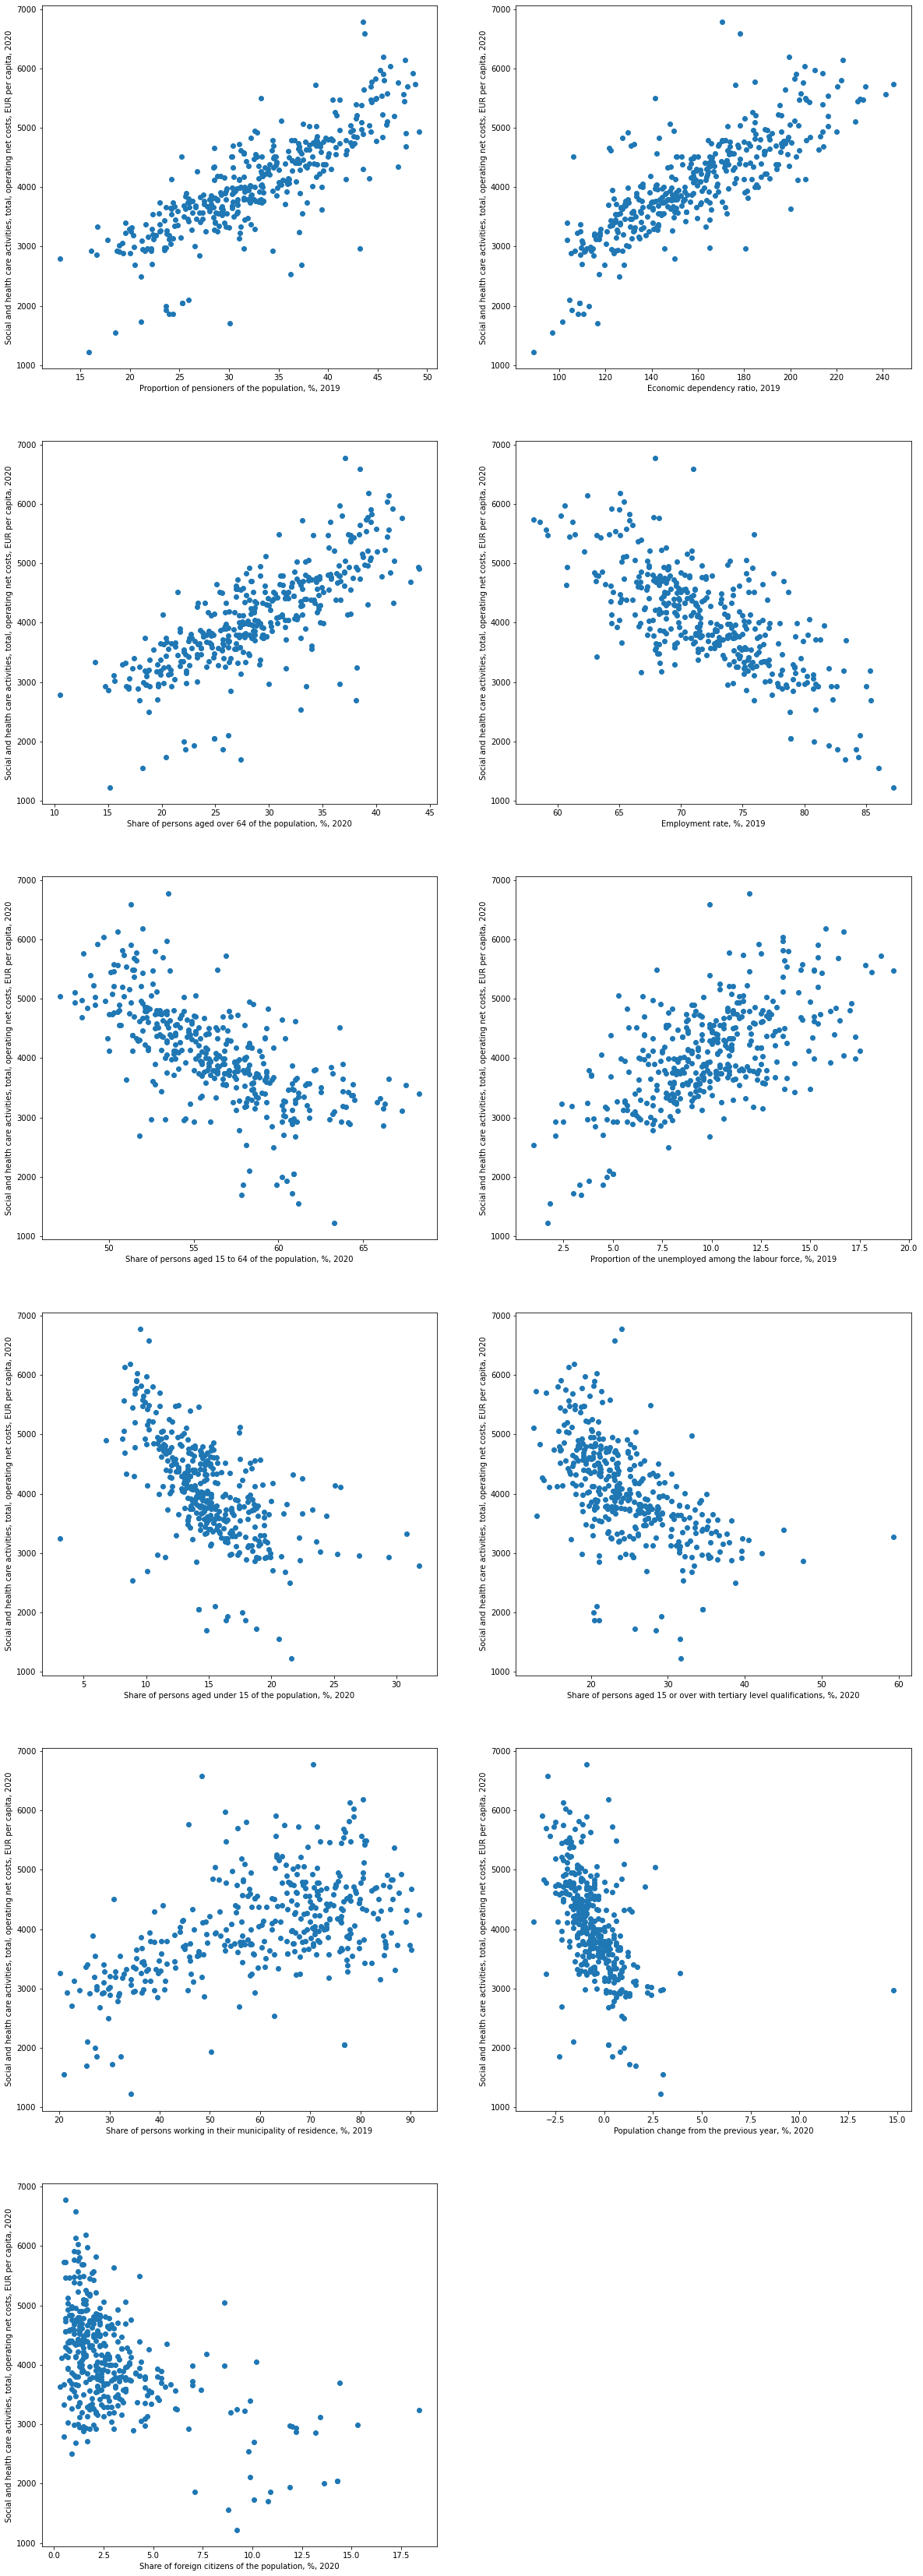

In [5]:
# Let's see if the response of selected variables is linear, or should some transformation be applied

plt.figure(figsize = (20,60))

for i, x_name in enumerate(x_names):
    plt.subplot(math.ceil(len(x_names)/2), 2, i+1)
    plt.scatter(x[x_name], y)
    plt.xlabel(x_name)
    plt.ylabel(y_name)

In [6]:
# Check if any target variables are NaN
np.isnan(y).sum()

# Create a vector holding the index of valid records
keep = y[np.isnan(y)==False].index

# Remove the non-valid records from x and y datasets
x = x.filter(items = keep, axis=0)
y = y.filter(items = keep)

# Fit linear regression model 
model = LinearRegression().fit(x, y)

# Print coefficents and intercept
print('Coefficients: ', model.coef_)
print('Intercept: ', model.intercept_)

Coefficients:  [224.05115703   0.30102815  70.59439402  19.05388242 231.96323482
  13.37355893 245.21475741   7.97367151  11.7164238  -67.07551783
 -42.92131864]
Intercept:  -24389.91979368452


In [7]:
# Apply the model
linest = model.predict(x)

In [8]:
# Score the model
from sklearn.metrics import mean_absolute_error

mae = (mean_absolute_error(y, linest))
r2 = model.score(x, y)

print('Model fit')
print('------------------------------------------')
print('Mean absolute error: {}'.format(mae))
print('Coefficient of determination: {}'.format(r2))

Model fit
------------------------------------------
Mean absolute error: 272.00447851169304
Coefficient of determination: 0.814570821558092


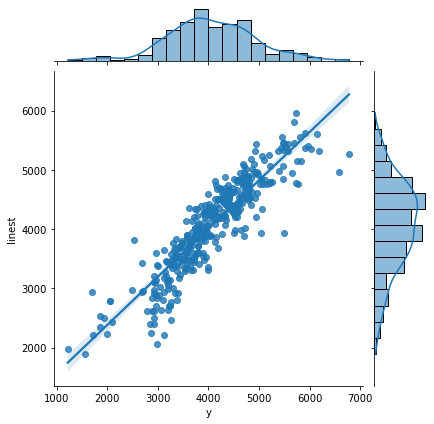

In [9]:
# Plot prediction vs actuals
import seaborn as sns
test = pd.DataFrame()
test['y'] = y
test['linest'] = linest

sns.jointplot(data=test, x = 'y', y = 'linest', kind = 'reg')

## Conclusions so far
- Not bad, while not perfect
- There's some non-linearity in the lower spectrum of values missed by the model
    - One could try eliminating outliers in order to get better overall fit
    - Or alternatively try adding some non-linear function to x in order to capture the slightly bell shaped response
- One should also take into account that data was not split in proper training and testing sets, the results might not represent real life situation


In [10]:
# Instead of tinkering with transformations on x, let's act lika a proper citizen-scientist and import some libraries to play with instead
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [11]:
# A common function for comparing different models
from sklearn.metrics import mean_squared_error

def tryModel(model):
    model.fit(x, y)
    predict = model.predict(x)

    # Yes, these were already described as is - maybe later refactoring will introduce this function a bit earlier..
    rms = mean_squared_error(y, predict, squared=True)
    r2 = model.score(x, y)

    print(type(model).__name__ + ' model fit')
    print('------------------------------------------')
    print('RMSE: ' + str(round(rms)))
    print('R2: ' + str(round(r2,4)))

    test = pd.DataFrame()
    test['y'] = y
    test['predict'] = predict

    sns.jointplot(data=test, x = 'y', y = 'predict', kind = 'reg')


LinearRegression model fit
------------------------------------------
RMSE: 131577
R2: 0.8146


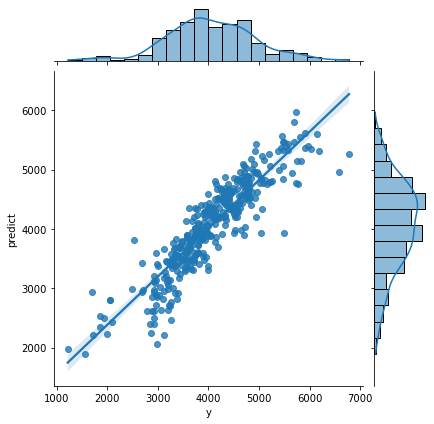

In [12]:
model = LinearRegression()
tryModel(model)

RandomForestRegressor model fit
------------------------------------------
RMSE: 18668
R2: 0.9737


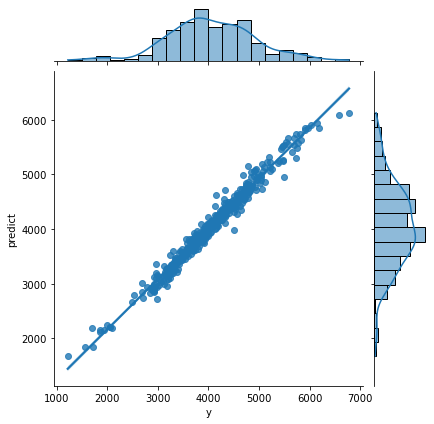

In [13]:
model = RandomForestRegressor()
tryModel(model)

GradientBoostingRegressor model fit
------------------------------------------
RMSE: 24448
R2: 0.9655


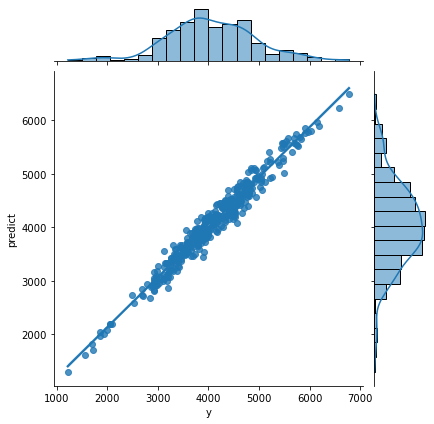

In [14]:
model = GradientBoostingRegressor()
tryModel(model)

## Final thoughts
Having the lowest RMSE and highest R2 coefficents, random forest came out as a champion on the given scenario
Gradient boosting did also fine compared to the basic linear regression

All results should be condsidered indicative at most, as the entire dataset was used both training and testing the model
Regardless of this experiement limitation, ensemble models showed their strenght in capturing the interaction between the features and the label